In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import sys
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve
from sklearn import metrics

import scipy

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
sys.path.append('/sise/home/shakarch/muscle-formation-diff')
sys.path.append(os.path.abspath('..'))
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

from TimeSeriesAnalysis.utils.data_load_save import *
from TimeSeriesAnalysis.utils.diff_tracker_utils import *
from TimeSeriesAnalysis.utils.plots_functions_utils import *
from TimeSeriesAnalysis.auc_over_time_diff_prob import *
import TimeSeriesAnalysis.params as params
import TimeSeriesAnalysis.consts as consts

In [3]:
# load fuaion data:

def load_fusion_data(path=consts.storage_path + r"data/mastodon/no_reg_S3 all detections.csv"):
   # load the raw data with fusion tags
    df = pd.read_csv(path, encoding="cp1252", header=[0, 1]) # header=[0, 1]
    df.columns = ['_'.join(col) for col in df.columns]
    df = df[df["manual_manual"] == 1]
    df.rename(columns=lambda x: x.replace("_", " ").strip(), inplace=True)
    fusion_cols = ['Spot track ID', 'Spot frame', 'Spot position X', 'Spot position Y', 'manual manual'] + [col for col in df.columns if "First" in col]
    df = df[fusion_cols]
    df.rename(columns=lambda x: x.split(" ")[3] if "First" in x else x, inplace=True)
    df = df[1:]
    df = df.astype(float)

    c = df.iloc[:,5:].idxmax(axis=1)
    is_valid = df.iloc[:,5:].sum(axis=1) > 0
    c[~is_valid] = np.nan
    df["fusion_frame"] = c
    df = df.dropna(subset=["fusion_frame"])
    df = df.drop_duplicates(subset=['fusion_frame', 'Spot track ID'])
    fusion_time_df = df[['Spot track ID' ,'fusion_frame']] #,'manual manual'
    fusion_time_df["fusion_time"] = fusion_time_df["fusion_frame"].astype(float) * 5 / 60
    return fusion_time_df
    
def convert_score_df(score_df, modality):
    """converts the scores dataframe from horizontal to vertical view"""
    df = pd.DataFrame()
    for i in range(len(score_df)):
        track = score_df.iloc[i, :]
        tmp_df = pd.DataFrame({f"score_{modality}":track.drop(index="Spot track ID")})
        tmp_df["time"] = tmp_df.index * 5 / 60
        tmp_df["Spot frame"] = tmp_df.index
        tmp_df["Spot track ID"] = track["Spot track ID"]
        df = df.append(tmp_df, ignore_index=True)
    return df

# fusion_time_df = load_fusion_data(path=consts.storage_path + r"data/mastodon/no_reg_S3 all detections.csv")
tagged_tracks_s3, _ = get_tracks(consts.data_csv_path % (params.registration_method, "S3"), tagged_only=True)
tagged_tracks_s3 = tagged_tracks_s3.drop(columns="manual")

# fusion_scores = fusion_time_df.merge(tagged_tracks_s3.drop(columns="manual"), on=["Spot track ID"], how="left")
# del fusion_time_df
# del tagged_tracks_s3

scores_df_s3_mot = pickle.load(open(consts.motility_model_path + "df_prob_w=30, video_num=S3", 'rb'))
scores_df_s3_int = pickle.load(open(consts.intensity_model_path + "df_prob_w=30, video_num=S3", 'rb'))
scores_df_s3_mot = convert_score_df(scores_df_s3_mot, "motility")
scores_df_s3_int = convert_score_df(scores_df_s3_int, "intensity")

fusion_scores = tagged_tracks_s3.merge(scores_df_s3_mot, on=["Spot track ID", "Spot frame"], how="left")
fusion_scores = fusion_scores.merge(scores_df_s3_int[["Spot track ID", "Spot frame", "score_intensity"]], on=["Spot track ID", "Spot frame"], how="left")
del scores_df_s3_mot
del scores_df_s3_int

fusion_scores.head(3)

,Spot position X,Spot position Y,Spot frame,Spot track ID,score_motility,time,score_intensity
0,203.884064,356.669098,0,29722,NaN,0.0,NaN
1,760.951782,304.275787,0,29615,NaN,0.0,NaN
2,744.996399,360.262299,0,29608,NaN,0.0,NaN


In [4]:
fusion_scores_s3 = fusion_scores

In [5]:
fusion_scores_s3 = fusion_scores_s3.sort_values("Spot frame")

In [10]:
def get_all_properties_df(modality, con_train_vid_num, diff_train_vid_num, scores_vid_num,
                          reg_method=params.registration_method):
    properties_data_path = fr"/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/13-11-2022-{modality} local dens-False, s{con_train_vid_num}, s{diff_train_vid_num} train" + (
        " win size 16" if modality != "motility" else "") + fr"/track len 30, impute_func-{params.impute_methodology}_{params.impute_func} reg {reg_method}/S{scores_vid_num}_properties_{reg_method}"
    properties_df = pickle.load(open(properties_data_path + ".pkl", 'rb'))
    return properties_df

properties_df_s5 =  get_all_properties_df("actin_intensity", 2, 3, scores_vid_num=5)
properties_df_s1 =  get_all_properties_df("actin_intensity", 2, 3, scores_vid_num=1)
properties_df_s3 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=3)
properties_df_s2 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=2)

pd.set_option("max_columns",30)
properties_df_s3.head(5)

,score_motility,score_intensity,coordination,local_density,Spot frame,time,Spot track ID,min,max,mean,sum,x,y,persistence,directionality_cos_alpha,speed,speed_change,Spot position X,Spot position Y
0,0.928833323,0.190785791,NaN,6.000000000,82.000000000,6.833333333,1.000000000,188.000000000,711.000000000,379.057617188,"388,155.000000000","2,041.000000000","2,504.000000000",0.072408952,0.641977368,2.890145063,-0.533617258,943.222656250,"1,156.871826172"
1,0.920083905,0.201096767,NaN,6.000000000,83.000000000,6.916666667,1.000000000,230.000000000,763.000000000,392.603515625,"402,026.000000000","2,041.000000000","2,493.000000000",0.060796279,-0.006073134,4.653162003,1.763016939,943.194396973,"1,152.218750000"
2,0.900846115,0.191633820,NaN,6.000000000,84.000000000,7.000000000,1.000000000,186.000000000,"1,121.000000000",371.957031250,"380,884.000000000","2,041.000000000","2,484.000000000",0.050120454,-0.023498733,4.394768238,-0.258393764,943.091125488,"1,147.825195312"
3,0.900690242,0.226351883,NaN,6.000000000,85.000000000,7.083333333,1.000000000,106.000000000,"1,583.000000000",375.641601562,"384,657.000000000","2,042.000000000","2,472.000000000",0.020903893,0.059311154,5.429358006,1.034589767,943.413146973,"1,142.405395508"
4,0.911806196,0.263553191,NaN,6.000000000,86.000000000,7.166666667,1.000000000,182.000000000,"4,881.000000000",586.167968750,"600,236.000000000","2,040.000000000","2,462.000000000",0.058197703,-0.178587470,4.794979572,-0.634378433,942.556823730,"1,137.687500000"


In [13]:
properties_df_s3.sort_values("time")

,Spot track ID,Spot frame,score_motility,score_intensity,coordination,local_density,time,min,max,mean,sum,persistence,directionality_cos_alpha,Spot position X,Spot position Y
14296,"6,311.000000000",29.000000000,0.242069677,0.102093476,NaN,15.000000000,2.416666667,0.000000000,665.000000000,142.127155172,"131,894.000000000",0.545748949,0.973781728,"1,393.332763672",387.349395752
70491,"29,087.000000000",30.000000000,0.700173108,0.127523088,NaN,17.000000000,2.500000000,251.000000000,607.000000000,433.935546875,"444,350.000000000",0.896654248,-0.462137301,434.047302246,"1,096.848999023"
14297,"6,311.000000000",30.000000000,0.311330120,0.059263353,NaN,15.000000000,2.500000000,0.000000000,642.000000000,154.859375000,"109,021.000000000",0.576339483,0.969395330,"1,396.360351562",388.116149902
14298,"6,311.000000000",31.000000000,0.321586530,0.064835340,NaN,19.000000000,2.583333333,0.000000000,591.000000000,59.658653846,"24,818.000000000",0.591287076,0.747809496,"1,400.641113281",391.916656494
70492,"29,087.000000000",31.000000000,0.793175741,0.106124990,NaN,14.000000000,2.583333333,128.000000000,620.000000000,336.380859375,"344,454.000000000",0.887868285,-0.977191888,430.701690674,"1,097.576049805"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17454,"7,339.000000000",258.000000000,0.603284628,0.325131952,NaN,18.000000000,21.500000000,141.000000000,774.000000000,339.175781250,"347,316.000000000",0.850375235,-0.995157752,830.443725586,"1,138.946777344"
53840,"20,107.000000000",258.000000000,0.206319371,0.807985561,NaN,15.000000000,21.500000000,150.000000000,976.000000000,456.708007812,"467,669.000000000",0.579495251,-0.965036463,"1,204.310668945",274.477508545
17520,"7,382.000000000",258.000000000,0.605927932,0.244171654,NaN,9.000000000,21.500000000,228.000000000,758.000000000,373.728515625,"382,698.000000000",0.090007208,-0.198452667,485.014739990,977.969848633
16131,"6,843.000000000",258.000000000,0.678212824,0.797108822,NaN,17.000000000,21.500000000,161.000000000,535.000000000,300.266601562,"307,473.000000000",0.134320810,0.554682430,984.246398926,207.305526733


In [8]:
# re-add spot position columns and recalculate speed

def add_spot_position_columns(properties_df, vid_num):
    prop_cols = ["Spot track ID","Spot frame", "score_motility", "score_intensity","coordination", "local_density", 
                                                  "time", "min", "max", "mean", "sum", "persistence", "directionality_cos_alpha"]
    df_s_cols = ["Spot track ID","Spot frame","Spot position X", "Spot position Y"]
    
    path = fr'/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/data/mastodon/{params.registration_method}'
    s_df, s_track_list = get_tracks(path + f"S{vid_num} all detections.csv", manual_tagged_list=True)
    
    properties_df = pd.merge(left=properties_df[prop_cols], 
                                right=s_df.drop_duplicates(subset=["Spot track ID","Spot frame"])[df_s_cols] ,
                                on=["Spot track ID","Spot frame"], how='left')
    return properties_df
    
# properties_df_s3 = add_spot_position_columns(properties_df_s3, 3)
# properties_df_s2 = add_spot_position_columns(properties_df_s2, 2)

# properties_df_s1 = add_spot_position_columns(properties_df_s1, 1)
# properties_df_s5 = add_spot_position_columns(properties_df_s5, 5)


def get_new_speed(track_data):
    pd.options.display.float_format = '{:,.9f}'.format 
    x_col = "Spot position X"
    y_col = "Spot position Y"
    track_data["time"] = track_data["Spot frame"] * 5 / 60
    track_data = track_data[["Spot frame", x_col, y_col, "Spot track ID", "time"]]
    track_data = track_data.sort_values("Spot frame")

    track_data['speed_x'] = track_data.groupby(['Spot track ID'])[x_col].transform(lambda x: x.diff()) 
    track_data['speed_y'] = track_data.groupby(['Spot track ID'])[y_col].transform(lambda x: x.diff()) 

    track_data["speed"] = np.sqrt(np.square(track_data["speed_x"]) + np.square(track_data["speed_y"]))
    track_data['speed_change'] = track_data.groupby(['Spot track ID'])['speed'].diff()#.transform(lambda x: x.pct_change()) 
    
    return track_data["speed"], track_data['speed_change']

# properties_df_s3["speed"], properties_df_s3['speed_change'] = get_new_speed(properties_df_s3)
# properties_df_s2["speed"], properties_df_s2['speed_change'] = get_new_speed(properties_df_s2)

# properties_df_s5["speed"], properties_df_s5['speed_change'] = get_new_speed(properties_df_s5)
# properties_df_s1["speed"], properties_df_s1['speed_change'] = get_new_speed(properties_df_s1)


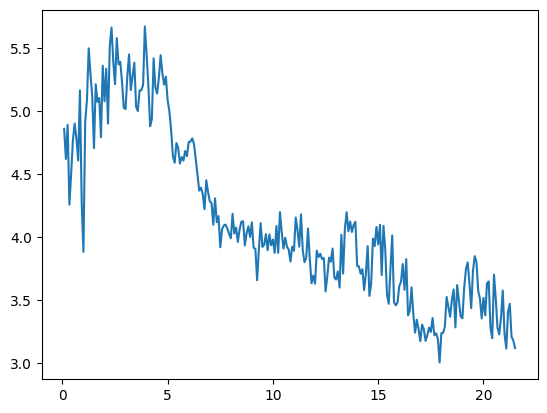

In [13]:
fusion_scores_s3["speed"], fusion_scores_s3['speed_change'] = get_new_speed(fusion_scores_s3)
plt.plot(fusion_scores_s3.groupby("time")["speed"].mean())

In [25]:
fusion_scores_s3

,Spot position X,Spot position Y,Spot frame,Spot track ID,score_motility,time,score_intensity,speed,speed_change
0,203.884063721,356.669097900,0,29722,NaN,0.0,NaN,NaN,NaN
20,992.146423340,613.971069336,0,498,NaN,0.0,NaN,NaN,NaN
21,"1,288.666870117",228.376846313,0,28532,NaN,0.0,NaN,NaN,NaN
22,973.938476562,289.571319580,0,28513,NaN,0.0,NaN,NaN,NaN
23,"1,087.353271484",341.559234619,0,1058,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
111151,593.076782227,834.447143555,258,2681,0.591393937,21.5,0.760941798,9.166957855,-0.158401489
111152,567.470031738,845.065063477,258,20894,0.613039888,21.5,0.487017154,2.049274921,0.346931219
111153,488.658996582,826.084106445,258,27013,0.482117576,21.5,0.786056707,0.507237434,-2.086742163
111568,"1,596.852416992","1,330.155517578",258,9295,0.276916651,21.5,0.281043356,0.679968238,-1.896916509


In [21]:
from TimeSeriesAnalysis.single_cell_properties_calc import *
    
def get_new_persistence(data, rolling_w=30):
    data = data.sort_values("Spot frame")
    xx =  data.groupby(['Spot track ID'], as_index=True)[["Spot position X", "Spot position Y", "Spot frame"]].apply(lambda x: get_persistence_df(x, rolling_w))
    
    return pd.merge(data, xx, on=['Spot track ID', 'Spot frame',], how='left')

# properties_df_s3 = get_new_persistence(properties_df_s3, rolling_w=30)
# properties_df_s2 = get_new_persistence(properties_df_s2, rolling_w=30)
# properties_df_s1 = get_new_persistence(properties_df_s1, rolling_w=30)
# properties_df_s5 = get_new_persistence(properties_df_s5, rolling_w=30)

In [27]:
fusion_scores_s3 = get_new_persistence(fusion_scores_s3, rolling_w=30)

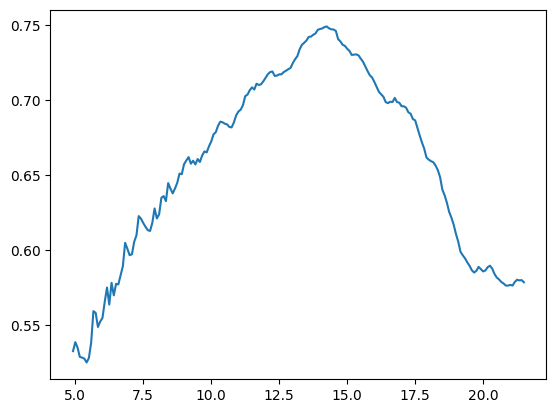

In [28]:
plt.plot(fusion_scores_s3.groupby("time")["persistence"].mean())

In [5]:
def plot_property_over_time(properties_df_lst, features_list, time=(0,25)):
    sns.set_style("darkgrid")
    dfs = list(map(lambda x: x[0], properties_df_lst))
    labels = list(map(lambda x: x[1], properties_df_lst))
    colors = list(map(lambda x: x[2], properties_df_lst))

    tot = len(features_list)
    cols = 2
    rows = tot // cols
    # EDIT for correct number of rows:
    # If one additional row is necessary -> add one:
    if tot % cols != 0:
        rows += 1
    position = range(1, tot + 1)
    fig = plt.figure(1, figsize=(14,14))

    for k in range(tot):
        f = features_list[k]
        ax = fig.add_subplot(rows, cols, position[k])
        for df, label, color in zip(dfs, labels, colors):   

            
            df = df[(df["time"]>= time[0]) & (df["time"]< time[1])]
            df = df.sort_values("time")
            mean = df.groupby("time")[f].mean()
            std = df.groupby("time")[f].std()
            ax.plot(mean, color=color, label=label)
            plt.fill_between(df["time"].unique(), mean - std, mean + std, alpha=0.4, color=color, label=label)
            
            ax.axvspan(6, 13, alpha=0.3, color='lightgray')
            ax.axvline(6, color='gray', linestyle='dashed')
            ax.axvline(13, color='gray', linestyle='dashed')
            
            ax.set_ylabel(f"{f}")
            ax.set_xlabel(f"time")
            ax.set_title(f'{f} over time')
            ax.legend()
            
    plt.savefig(consts.storage_path + f"eps_figs/property_over_time {str(labels)}.eps", format="eps")

time = (5,23)  
features_list = ["speed", "local_density", "persistence_x", "persistence_y", "mean"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


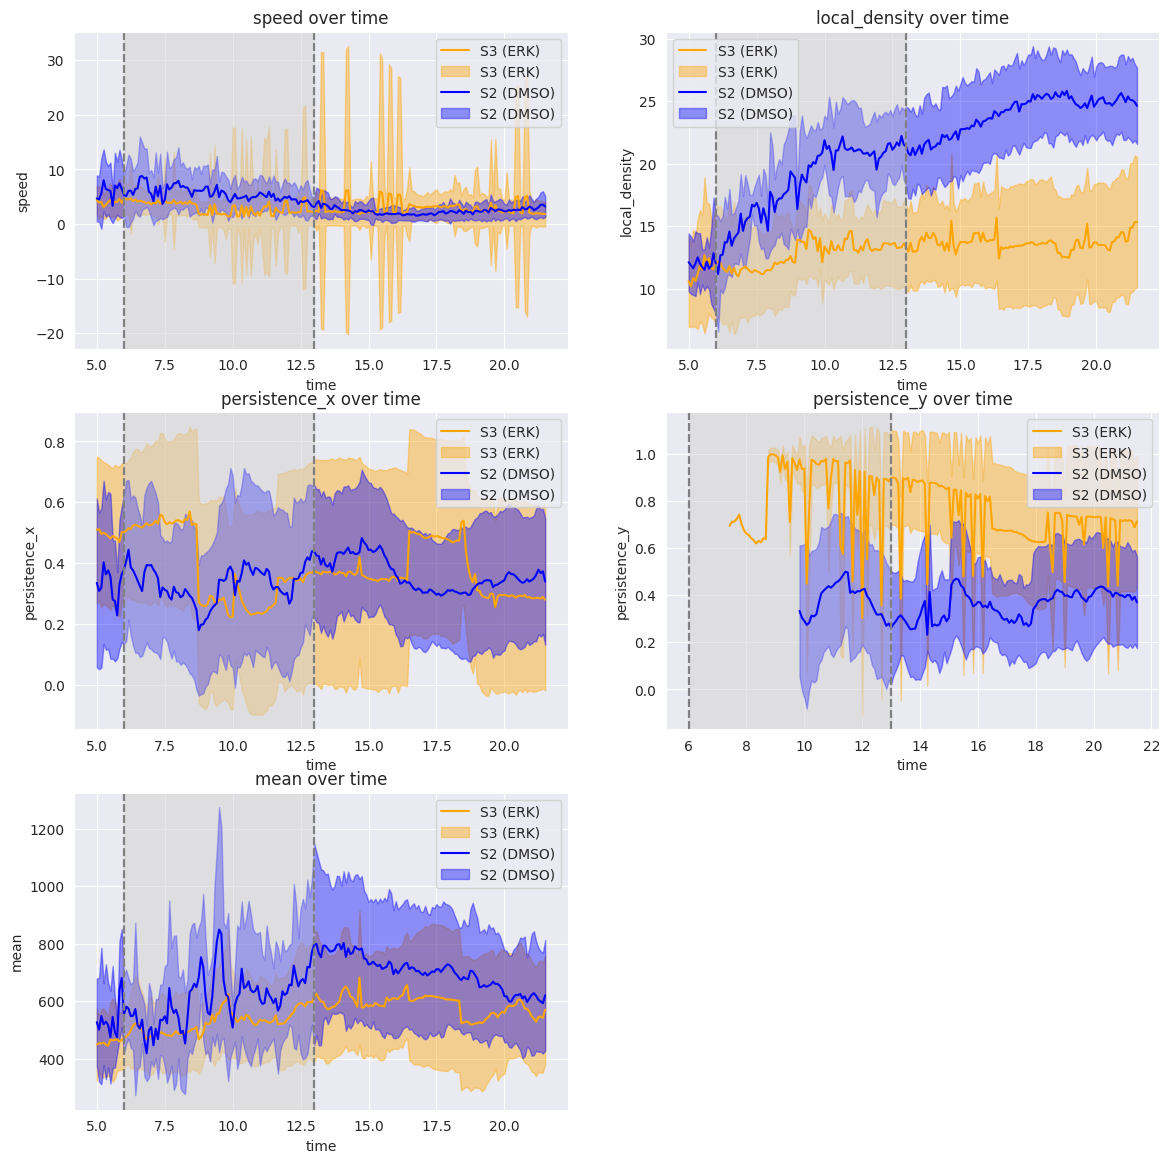

In [6]:
data = [(properties_df_s3, "S3 (ERK)","orange") ,(properties_df_s2, "S2 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


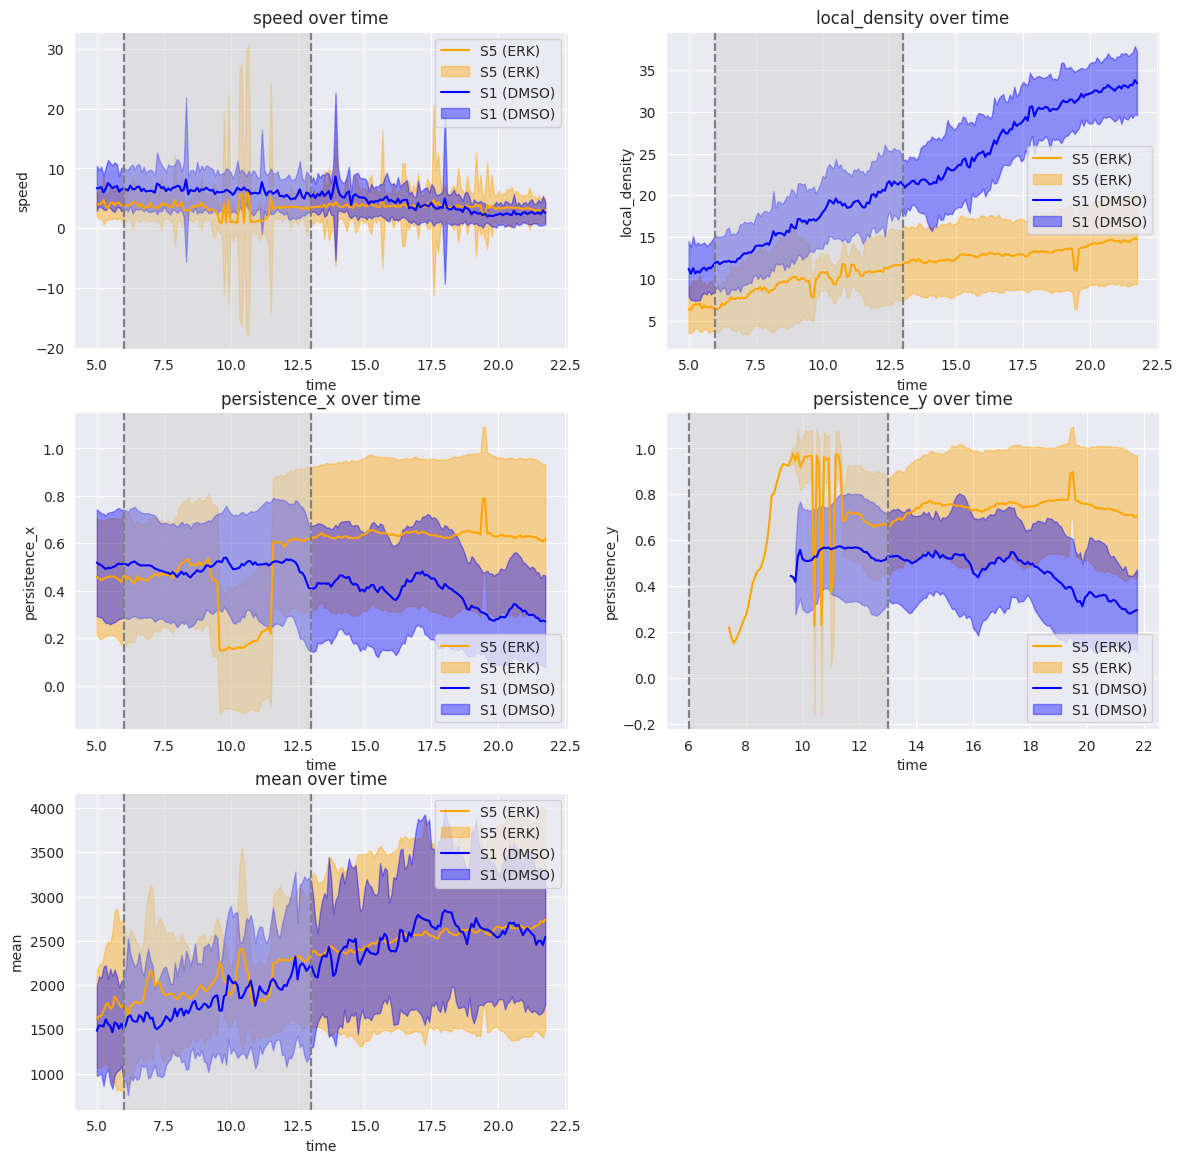

In [7]:
data = [(properties_df_s5, "S5 (ERK)","orange") ,(properties_df_s1, "S1 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

In [8]:
properties_df_s3

,Spot track ID,Spot frame,score_motility,score_intensity,coordination,local_density,time,min,max,mean,sum,persistence_x,directionality_cos_alpha,Spot position X,Spot position Y,speed,speed_change,persistence_y
0,"6,311.000000000",29.000000000,0.242069677,0.102093476,NaN,15.000000000,2.416666667,0.000000000,665.000000000,142.127155172,"131,894.000000000",0.545748949,0.973781728,"1,393.332763672",387.349395752,NaN,NaN,NaN
1,"29,087.000000000",30.000000000,0.700173108,0.127523088,NaN,17.000000000,2.500000000,251.000000000,607.000000000,433.935546875,"444,350.000000000",0.896654248,-0.462137301,434.047302246,"1,096.848999023",NaN,NaN,NaN
2,"6,311.000000000",30.000000000,0.311330120,0.059263353,NaN,15.000000000,2.500000000,0.000000000,642.000000000,154.859375000,"109,021.000000000",0.576339483,0.969395330,"1,396.360351562",388.116149902,3.123171568,NaN,NaN
3,"6,311.000000000",31.000000000,0.321586530,0.064835340,NaN,19.000000000,2.583333333,0.000000000,591.000000000,59.658653846,"24,818.000000000",0.591287076,0.747809496,"1,400.641113281",391.916656494,5.724401474,2.601229906,NaN
4,"29,087.000000000",31.000000000,0.793175741,0.106124990,NaN,14.000000000,2.583333333,128.000000000,620.000000000,336.380859375,"344,454.000000000",0.887868285,-0.977191888,430.701690674,"1,097.576049805",3.423699617,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109569,"7,339.000000000",258.000000000,0.603284628,0.325131952,NaN,18.000000000,21.500000000,141.000000000,774.000000000,339.175781250,"347,316.000000000",0.850375235,-0.995157752,830.443725586,"1,138.946777344",7.866399288,5.974550247,0.850375235
109570,"20,107.000000000",258.000000000,0.206319371,0.807985561,NaN,15.000000000,21.500000000,150.000000000,976.000000000,456.708007812,"467,669.000000000",0.579495251,-0.965036463,"1,204.310668945",274.477508545,6.455694675,4.411710739,0.579495251
109571,"7,382.000000000",258.000000000,0.605927932,0.244171654,NaN,9.000000000,21.500000000,228.000000000,758.000000000,373.728515625,"382,698.000000000",0.090007208,-0.198452667,485.014739990,977.969848633,6.458659649,0.715534210,NaN
109572,"6,843.000000000",258.000000000,0.678212824,0.797108822,NaN,17.000000000,21.500000000,161.000000000,535.000000000,300.266601562,"307,473.000000000",0.134320810,0.554682430,984.246398926,207.305526733,1.981972337,-1.521773219,0.944470048
